In [50]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np

In [51]:
START_DATE = datetime.date(2020,2,24)

In [52]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.show()
    return

In [53]:
def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_regione"]==region]["totale_casi"].sum())
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.show()
    return

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

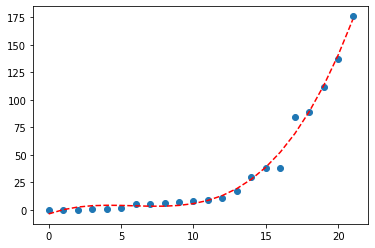

In [54]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

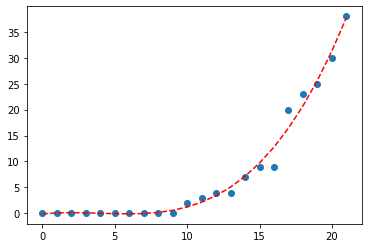

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

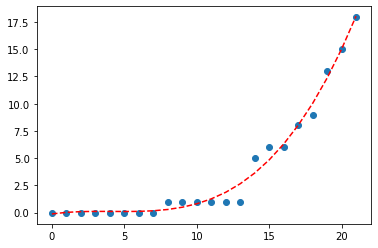

In [56]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

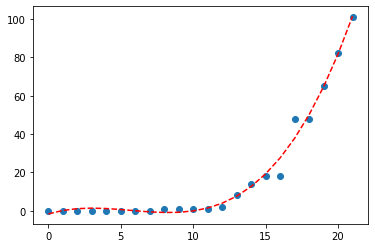

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

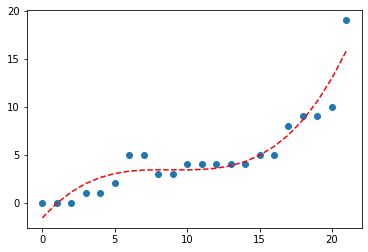

In [58]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

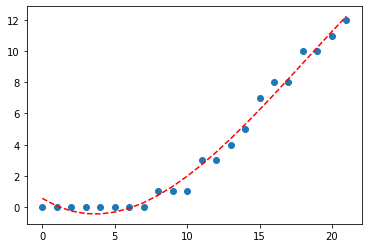

In [59]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

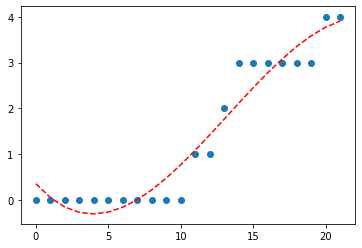

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

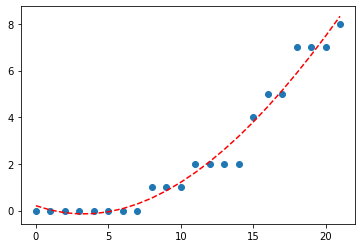

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 in Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

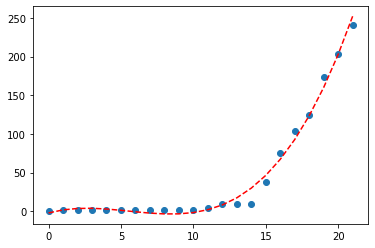

In [62]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

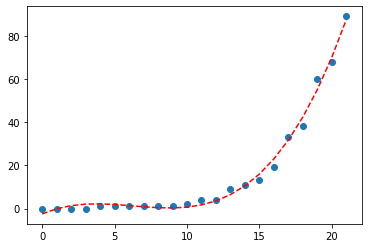

In [63]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

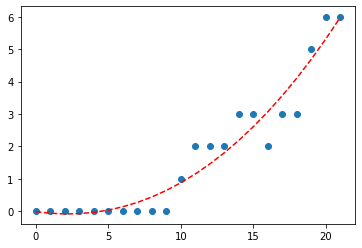

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

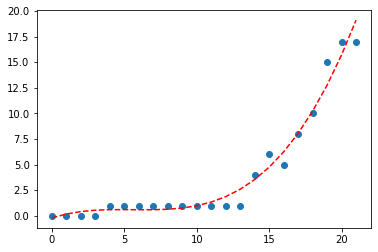

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

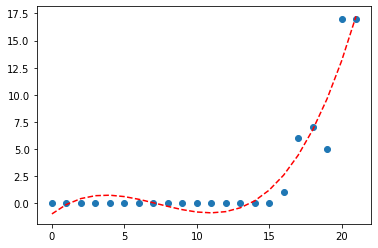

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

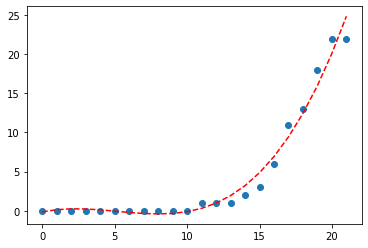

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

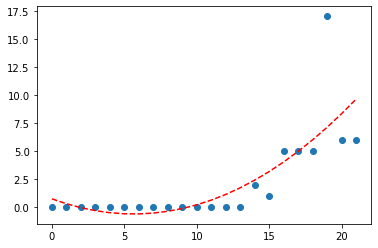

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

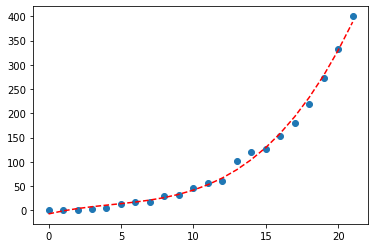

In [69]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

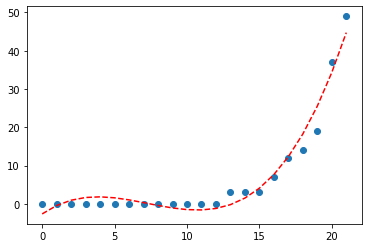

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

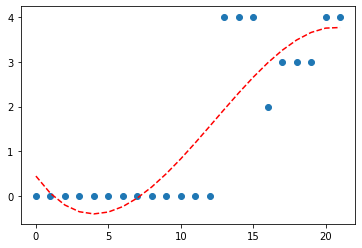

In [71]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

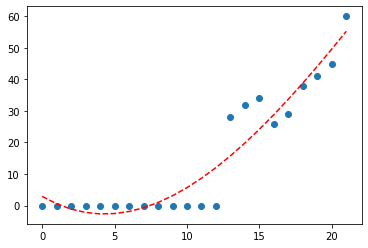

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

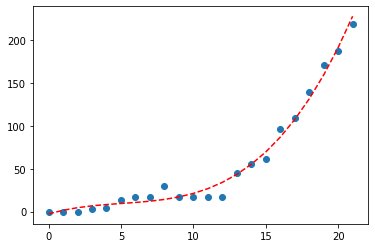

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

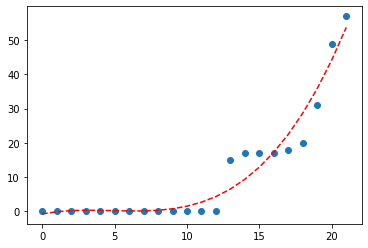

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

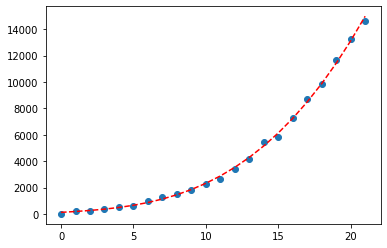

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

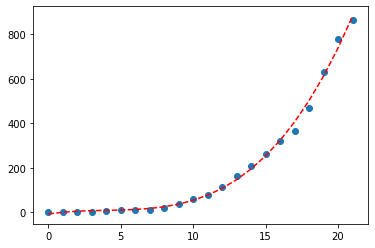

In [72]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

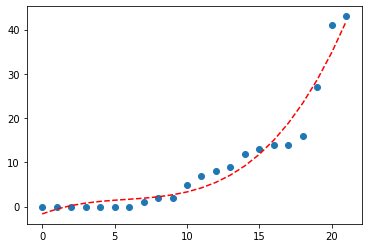

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

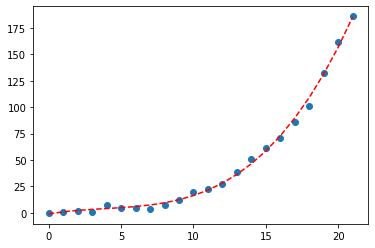

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

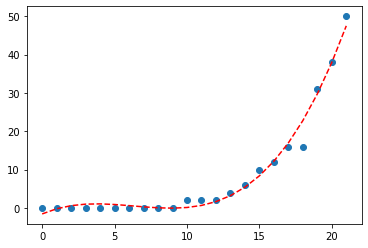

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

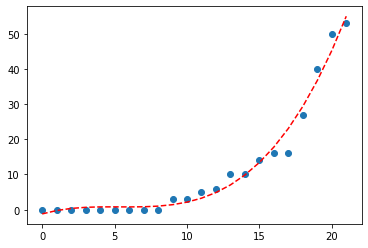

In [89]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

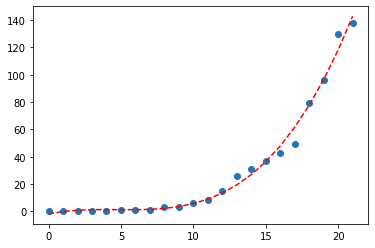

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

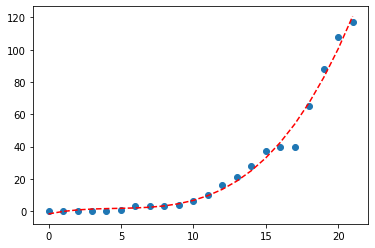

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

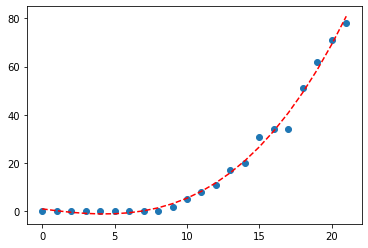

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

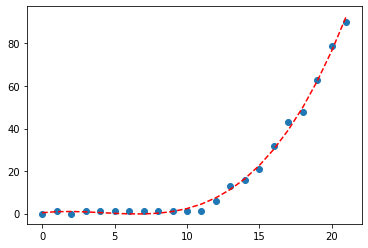

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

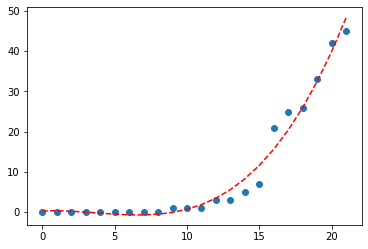

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

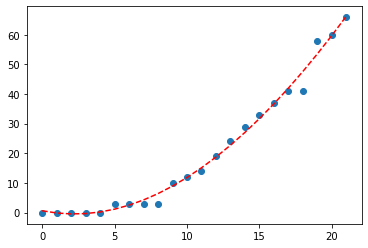

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

## Bergamo

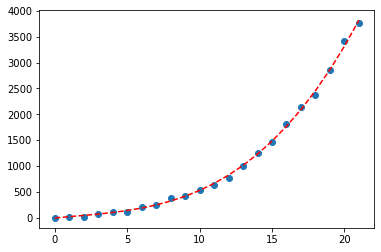

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Lodi

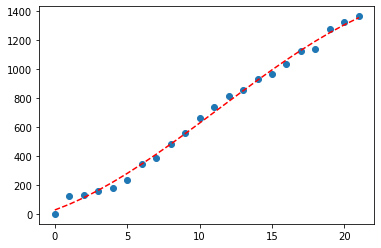

In [77]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Milano

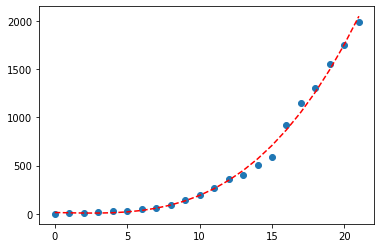

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

# Casi in Veneto

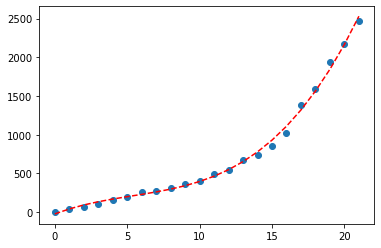

In [81]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Padova

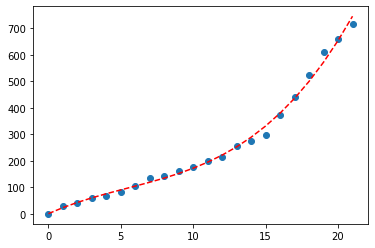

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')